In [3]:
import pandas as pd

In [2]:
df = pd.read_csv('../../data/data-2324-no-ver.csv')
df_ver = pd.read_csv('../../data/data-2324-ver.csv')
print(df.head(1))

   Unnamed: 0  incident_id report_id  date_coded  \
0           0          203        17  2024-02-12   

                                                 url  \
0  https://twitter.com/DouglasLucas/status/171631...   

                                                file screenshot date_posted  \
0  Screenshot 2024-02-12 at 12.47.24 PM.png (http...        NaN  2023-10-23   

  format transcript  ...                               text_around_deepfake  \
0  image        NaN  ...  AI and the end of photographic truth? Deceptiv...   

            harm_evidence communication_goal      core_frame       hero  \
0  political_interference          education  human_interest  Joe Biden   

  villain                      plot                                    moral  \
0   Putin  Putin and Biden hugging   U.S. and Russian leaders can get along    

        domain    year  
0  twitter.com  2023.0  

[1 rows x 60 columns]


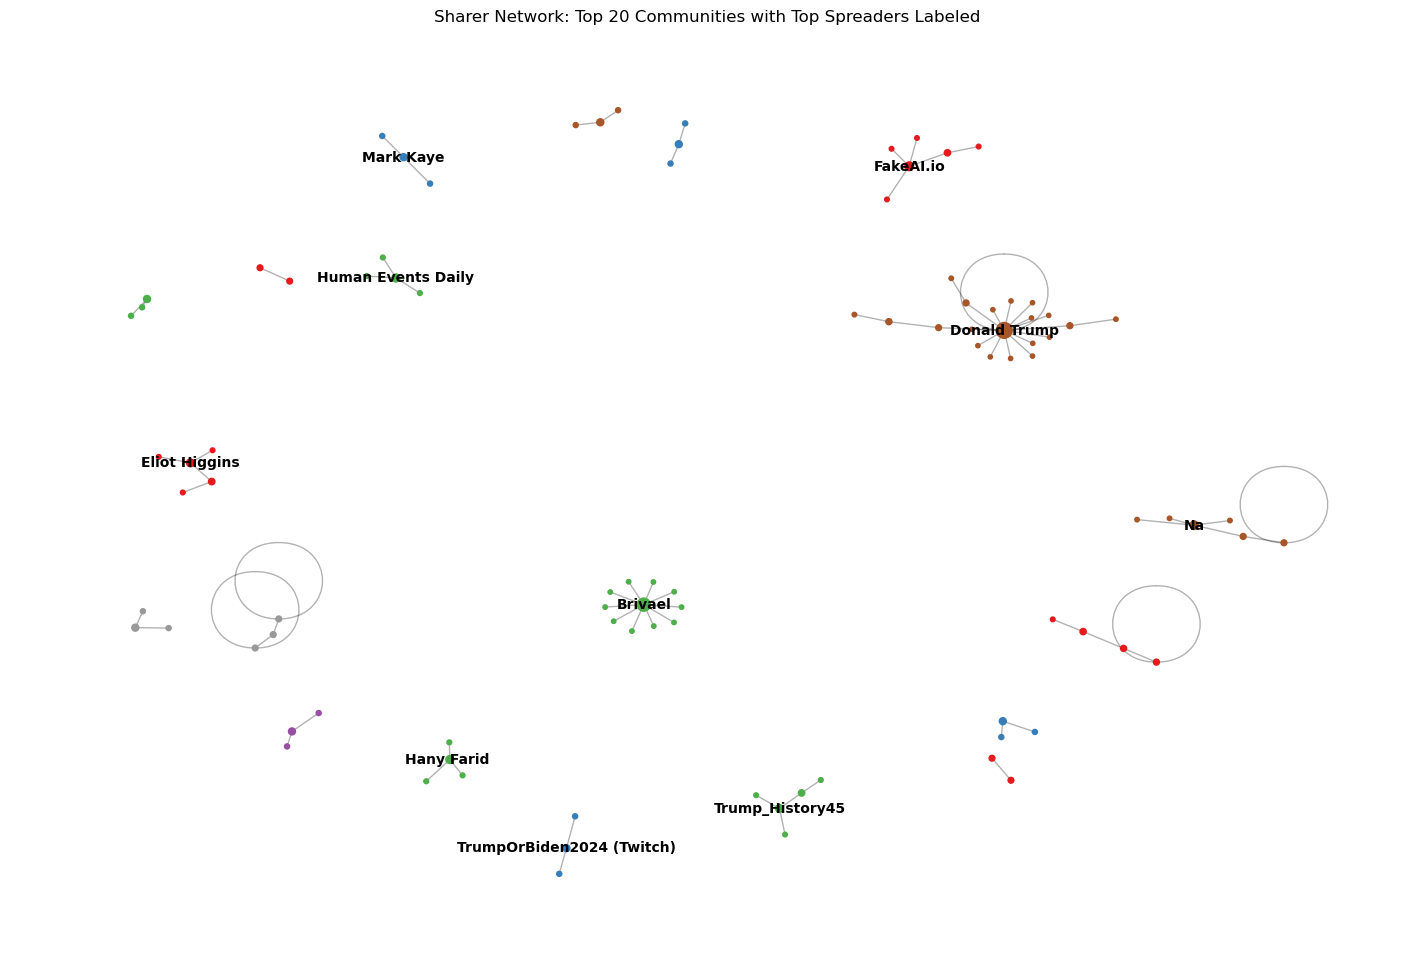

📢 Top Spreaders (excluding 'unknown' and 'other'):
- Donald Trump: 0.02586
- Brivael: 0.01787
- FakeAI.io: 0.00789
- Na: 0.00741
- Human Events Daily: 0.00668
- Hany Farid : 0.00668
- Eliot Higgins: 0.00623
- Trump_History45: 0.00623
- TrumpOrBiden2024 (Twitch): 0.00508
- Mark Kaye: 0.00508


In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain  # pip install python-louvain
import pandas as pd
from collections import Counter

# Create sharer network
G = nx.Graph()

# Define terms to exclude
excluded_names = {'unknown', 'other'}

# Add edges between original source and sharers, excluding unknown/other
for _, row in df.iterrows():
    source = str(row['original_source_name']).strip().lower()
    sharer = str(row['sharer_name']).strip().lower()
    
    if (source not in excluded_names and sharer not in excluded_names and
        pd.notna(row['original_source_name']) and pd.notna(row['sharer_name'])):
        
        G.add_edge(row['original_source_name'], row['sharer_name'])

# Louvain community detection
partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, partition, 'community')

# PageRank centrality
pagerank = nx.pagerank(G)
nx.set_node_attributes(G, pagerank, 'pagerank')

# Get top 20 communities by size
community_counts = Counter(partition.values())
top_20_communities = set([c for c, _ in community_counts.most_common(20)])

# Filter graph to include only nodes in top 20 communities
top_nodes = [n for n in G.nodes() if partition[n] in top_20_communities]
G_sub = G.subgraph(top_nodes)

# Get PageRank in subgraph
pagerank_sub = {n: pagerank[n] for n in G_sub.nodes()}
partition_sub = {n: partition[n] for n in G_sub.nodes()}

# Draw graph
plt.figure(figsize=(18, 12))
pos = nx.spring_layout(G_sub, seed=42)
cmap = plt.cm.Set1
colors = [partition_sub[node] for node in G_sub.nodes()]
node_sizes = [pagerank_sub[v] * 5000 for v in G_sub.nodes()]

# Draw nodes and edges
nx.draw_networkx_nodes(G_sub, pos, node_color=colors, node_size=node_sizes, cmap=cmap)
nx.draw_networkx_edges(G_sub, pos, alpha=0.3)

# Show top spreaders' names
top_spreaders = sorted(pagerank_sub.items(), key=lambda x: x[1], reverse=True)[:10]
labels = {node: node for node, _ in top_spreaders}
nx.draw_networkx_labels(G_sub, pos, labels=labels, font_size=10, font_weight='bold')

plt.title('Sharer Network: Top 20 Communities with Top Spreaders Labeled')
plt.axis('off')
plt.show()

# Print top spreaders
print("📢 Top Spreaders (excluding 'unknown' and 'other'):")
for name, score in top_spreaders:
    print(f"- {name}: {score:.5f}")



/var/folders/0w/ztf136hd3qg58qvf8fpnbr4r0000gn/T/ipykernel_9328/4013379487.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_df['self_targeted'] = trump_df.apply(is_self_targeted, axis=1)


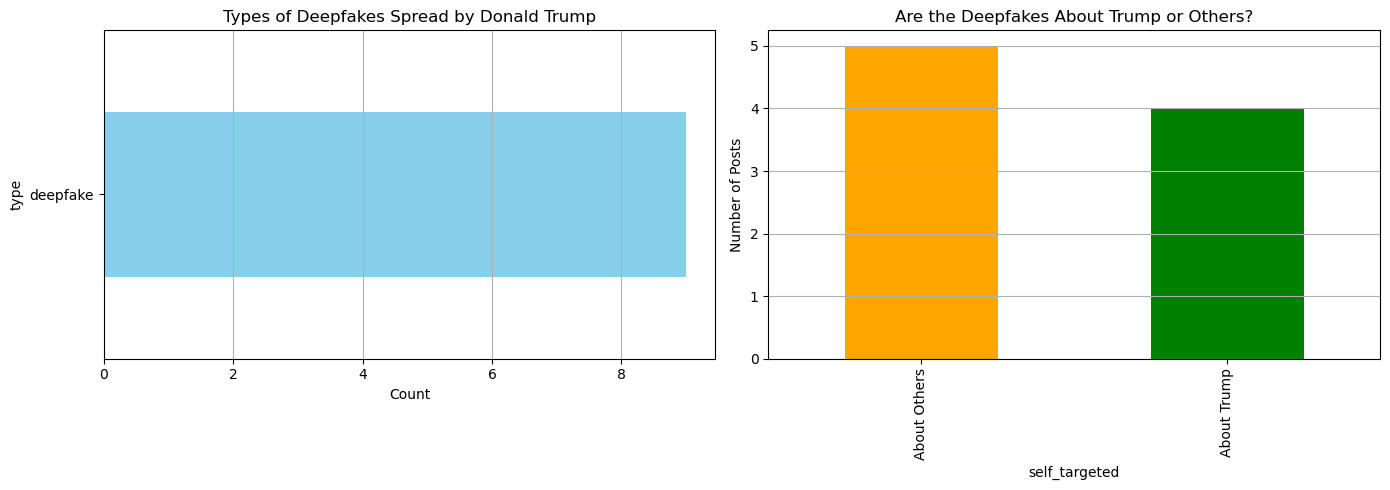

In [7]:
# Filter only posts shared by Donald Trump
trump_df = df[df['sharer_name'].str.lower() == 'donald trump']

# Count types of deepfakes he spread (use the 'type' or 'context_deepfake' column)
type_counts = trump_df['type'].value_counts()

# Determine whether the deepfakes target himself or others
def is_self_targeted(row):
    target_names = [str(row.get('target_name', '')).lower(),
                    str(row.get('target_one_name', '')).lower(),
                    str(row.get('target_two_name', '')).lower()]
    return any('trump' in name for name in target_names)

trump_df['self_targeted'] = trump_df.apply(is_self_targeted, axis=1)

# Count how many are about him vs. others
self_vs_others = trump_df['self_targeted'].value_counts().rename({True: 'About Trump', False: 'About Others'})

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Plot 1: Type of deepfakes
plt.subplot(1, 2, 1)
type_counts.plot(kind='barh', color='skyblue')
plt.title('Types of Deepfakes Spread by Donald Trump')
plt.xlabel('Count')
plt.grid(axis='x')

# Plot 2: Who the deepfakes are about
plt.subplot(1, 2, 2)
self_vs_others.plot(kind='bar', color=['orange', 'green'])
plt.title('Are the Deepfakes About Trump or Others?')
plt.ylabel('Number of Posts')
plt.grid(axis='y')

plt.tight_layout()
plt.show()


In [8]:
# Filter posts shared by Donald Trump
trump_df = df[df['sharer_name'].str.lower() == 'donald trump']

# Exclude self-targeting posts
def is_self_targeted(row):
    targets = [str(row.get('target_name', '')).lower(),
               str(row.get('target_one_name', '')).lower(),
               str(row.get('target_two_name', '')).lower()]
    return any('trump' in t for t in targets)

trump_df = trump_df[~trump_df.apply(is_self_targeted, axis=1)]

# Collect all target names into one list
from collections import Counter

targets = (
    trump_df['target_name'].dropna().tolist() +
    trump_df['target_one_name'].dropna().tolist() +
    trump_df['target_two_name'].dropna().tolist()
)

# Normalize: lowercase and strip whitespace
targets = [t.strip().lower() for t in targets if isinstance(t, str) and t.strip().lower() != '']

# Count frequencies
target_counts = Counter(targets)

# Convert to DataFrame for display
import pandas as pd
target_df = pd.DataFrame(target_counts.items(), columns=['target_name', 'count'])
target_df = target_df.sort_values(by='count', ascending=False)

# Show top 15
print("🧑‍🎯 Top Targets in Deepfakes Shared by Donald Trump (excluding himself):")
print(target_df.head(15).to_string(index=False))


🧑‍🎯 Top Targets in Deepfakes Shared by Donald Trump (excluding himself):
  target_name  count
 taylor swift      6
kamala harris      3


In [18]:
#print data where trump is the source
trump_source_df = df[df['sharer_name'].str.lower() == 'donald trump']
print("📢 Posts where Donald Trump is the original source:"
    )
print(trump_source_df[['original_source_name', 'sharer_name', 'type', 'summary_content']].head(10).to_string(index=False))

# print data where trump post a deepfake about himself
trump_self_df = df[(df['sharer_name'].str.lower() == 'donald trump') & 
                   (df['target_name'].str.lower().str.contains('trump'))]
print("📢 Posts where Donald Trump shared a deepfake about himself:")
print(trump_self_df[['original_source_name', 'sharer_name', 'type', 'summary_content']].head(10).to_string(index=False))

📢 Posts where Donald Trump is the original source:
original_source_name  sharer_name     type                                                                                                                                                                                                           summary_content
                 NaN Donald Trump deepfake                                                                                                                                                                        The image shows Donald Trump kneeling and praying.
                 NaN Donald Trump deepfake             Someone who looks like Kamala Harris is standing at a rally, addressing the audience. The rally has communist flags and symbols, as well as a Chicago sign, a nod toward the DNC that took place in Chicago. 
        Donald Trump Donald Trump deepfake                                                                                                                            

In [6]:
# Basic stats
print(f"Number of Nodes (Sharers + Sources): {G.number_of_nodes()}")
print(f"Number of Edges (Connections): {G.number_of_edges()}")
print(f"Average Degree: {sum(dict(G.degree()).values())/G.number_of_nodes():.2f}")
print(f"Density of the Network: {nx.density(G):.4f}")
print(f"Number of Connected Components: {nx.number_connected_components(G)}")

# Size of largest connected component
largest_cc = max(nx.connected_components(G), key=len)
print(f"Size of Largest Connected Component: {len(largest_cc)}")


Number of Nodes (Sharers + Sources): 287
Number of Edges (Connections): 227
Average Degree: 1.58
Density of the Network: 0.0055
Number of Connected Components: 161
Size of Largest Connected Component: 20


Top Sharers by Degree Centrality: [('Donald Trump', 0.05944055944055944), ('Brivael', 0.03496503496503497), ('FakeAI.io', 0.013986013986013986), ('Na', 0.013986013986013986), ('No Context French', 0.01048951048951049), ('CypherTux', 0.01048951048951049), ('Eliot Higgins', 0.01048951048951049), ('Trump_History45', 0.01048951048951049), ('Human Events Daily', 0.01048951048951049), ('Hany Farid ', 0.01048951048951049)]


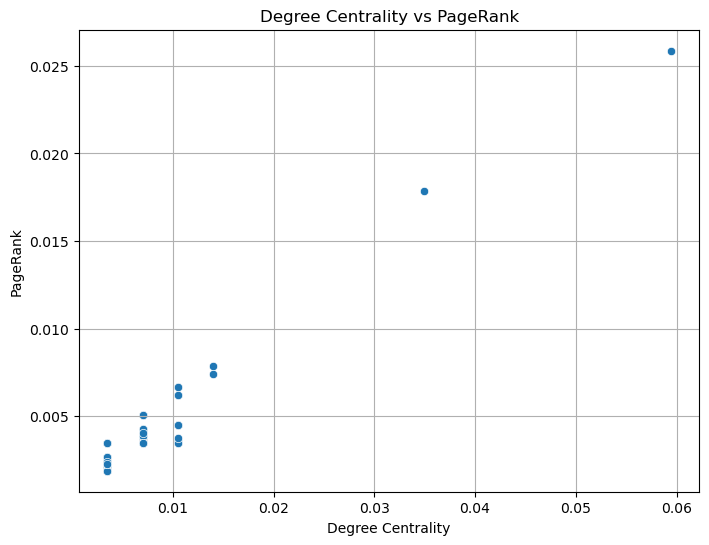

In [9]:
degree_centrality = nx.degree_centrality(G)

# Top 10 by degree
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Sharers by Degree Centrality:", top_degree)


centrality_df = pd.DataFrame({
    'node': list(degree_centrality.keys()),
    'degree_centrality': list(degree_centrality.values()),
    'pagerank': [pagerank.get(node, 0) for node in degree_centrality.keys()],
    'community': [partition.get(node, -1) for node in degree_centrality.keys()]
})

# Plot Degree vs PageRank
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(data=centrality_df, x='degree_centrality', y='pagerank')
plt.title('Degree Centrality vs PageRank')
plt.xlabel('Degree Centrality')
plt.ylabel('PageRank')
plt.grid(True)
plt.show()


In [10]:
# Group nodes by community
community_members = {}
for node, comm in partition.items():
    if comm not in community_members:
        community_members[comm] = []
    community_members[comm].append(node)

# Top 5 communities by size
largest_communities = sorted(community_members.items(), key=lambda x: len(x[1]), reverse=True)[:5]

for idx, (comm, members) in enumerate(largest_communities, 1):
    print(f"\nCommunity {idx} (size={len(members)}):")
    print(", ".join(members[:10]) + ('...' if len(members) > 10 else ''))  # print top 10 members



Community 1 (size=20):
Cyncratic, @TraficBerbat, @Sassafrass_84, @Sassafrass_84 , Brain Hirsh, Brian Hirsh , Donald Trump, @akafacehots, Rusty Sutton , Dare Obasanjo...

Community 2 (size=11):
Brivael, Min Choi, Lightway, Brian Potra, Barsee, Asim Rehman, MalikShabaaz, Kenny Le, Leonardo Dias, Economic Times...

Community 3 (size=6):
FakeAI.io, heythatsmydrink, o2slo2.0, michelle_pearl_knows , cblase2, Leroy Sickler 

Community 4 (size=6):
Na, Ann Stein , Brick Suit (Blake Marnell), Ginny M, Creative Automation, GinnyM

Community 5 (size=5):
Eliot Higgins, Eliot Higgins , Eliot Higgins Twitter page, Eliot Higgin, Elliot Higgins


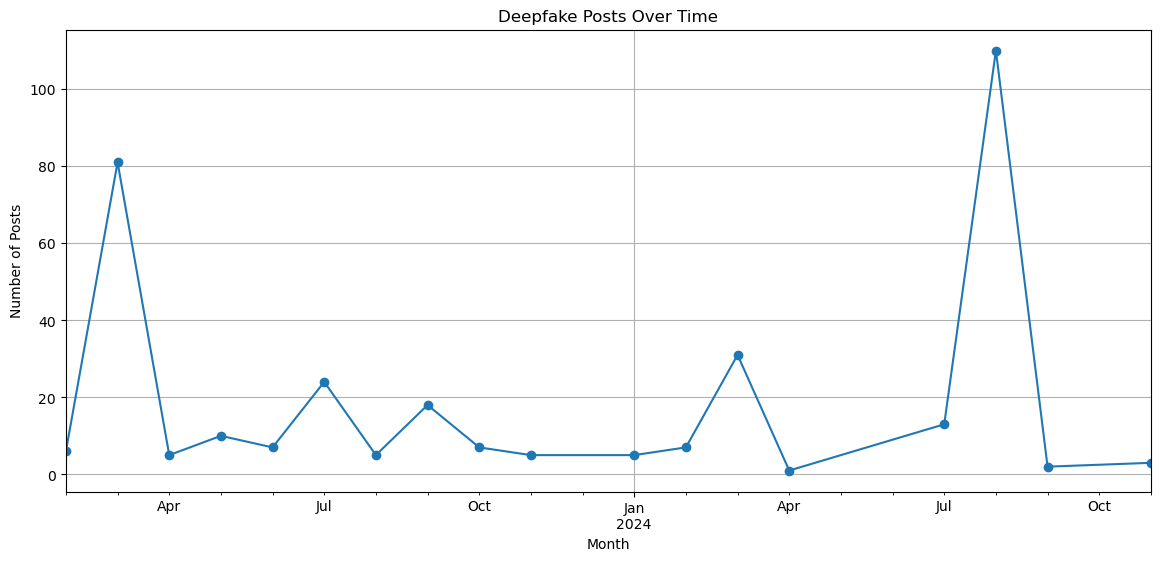

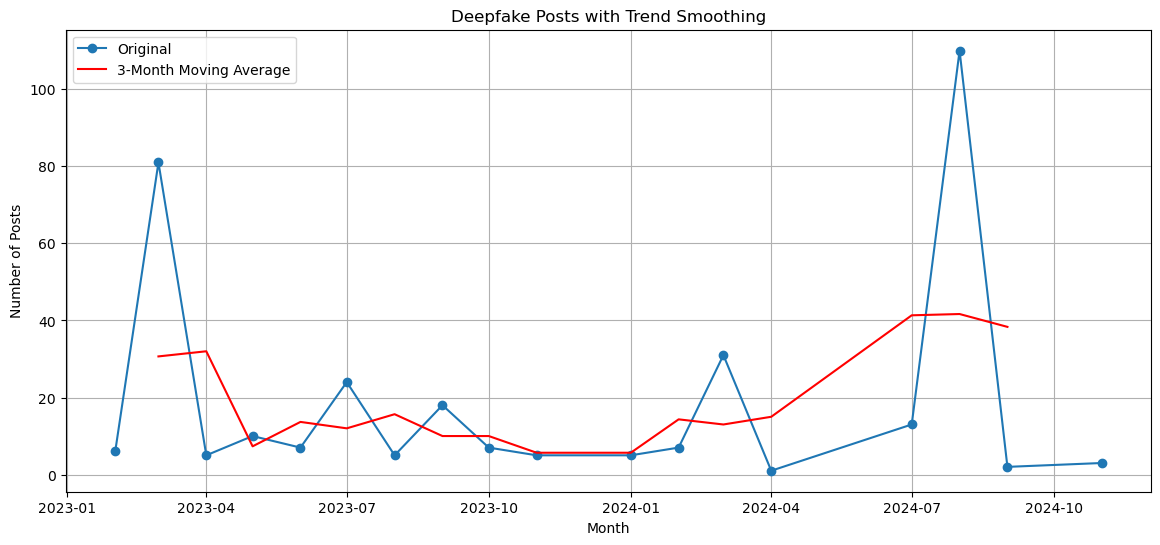

In [11]:
import seaborn as sns


# Ensure datetime format
df_ver['date_posted'] = pd.to_datetime(df_ver['date_posted'], errors='coerce')

# Posts per month
time_series = df_ver.groupby(df_ver['date_posted'].dt.to_period('M')).size()

# Plot time series
time_series.plot(figsize=(14, 6), marker='o')
plt.title('Deepfake Posts Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.grid()
plt.show()

# Moving average smoothing instead
ts = time_series.to_timestamp()
ts_rolling = ts.rolling(window=3, center=True).mean()

plt.figure(figsize=(14,6))
plt.plot(ts, label='Original', marker='o')
plt.plot(ts_rolling, label='3-Month Moving Average', color='red')
plt.title('Deepfake Posts with Trend Smoothing')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.legend()
plt.grid()
plt.show()


In [12]:
import plotly.graph_objects as go

# Define values to exclude (case-insensitive)
exclude_values = {"n/a", "na", "unknown", "NA", "other", ' NA', 'na','n/a ', "Na", "Other"}
# Convert to lowercase and filter rows that don't contain excluded values
df_filtered = df[
    df['original_source_country'].str.lower().apply(lambda x: x not in exclude_values) &
    df['sharer_country'].str.lower().apply(lambda x: x not in exclude_values)
].copy()

print(df.original_source_country.unique())
# Group flows
flows = df_filtered.groupby(['original_source_country', 'sharer_country']).size().reset_index(name='count')

# Prepare Sankey diagram data
sources = flows['original_source_country'].tolist()
targets = flows['sharer_country'].tolist()
values = flows['count'].tolist()

# Unique labels
labels = list(set(sources + targets))
label_to_index = {label: i for i, label in enumerate(labels)}

# Map labels to indices
source_indices = [label_to_index[src] for src in sources]
target_indices = [label_to_index[tgt] for tgt in targets]

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5),
              label=labels),
    link=dict(source=source_indices, target=target_indices, value=values)
)])

fig.update_layout(title_text="Cross-Country Deepfake Dissemination (Filtered)", font_size=10)
fig.show()



['United States ' ' NA' 'France'
 'The photo takes place in the United States. ' 'United Kingdom '
 'Netherlands ' 'Netherlands/Britain' 'Britain/Netherlands' 'Australia'
 'USA ' 'US ' 'na' 'n/a ' 'unknown' 'Egypt' 'Switzerland '
 'Czech Republic' 'United States of America' 'Canada ' 'Na' 'USa ' 'Italy'
 'Other']


In [19]:
print(df.sharer_type.unique())

['individual' 'individual,high_impact_user'
 'individual,group,high_impact_user' 'non-identifiable'
 'non-identifiable,high_impact_user' 'bot' 'group'
 'group,high_impact_user' 'high_impact_user,non-identifiable'
 'individual,bot' 'high_impact_user,individual' 'high_impact_user'
 'non-identifiable,individual' 'individual,non-identifiable'
 'high_impact_user,non-identifiable,individual,bot'
 'group,non-identifiable,individual']


In [23]:
# modify the value of sharer_type example: if sharer_type is high_impact_user,individual modify it to individual
df['sharer_type'] = df['sharer_type'].str.lower().replace({
    'individual,high_impact_user': 'individual',
    'non-identifiable,high_impact_user': 'non-identifiable',
    'group,high_impact_user': 'group',
    'high_impact_user,non-identifiable': 'non-identifiable',
    'high_impact_user,individual': 'individual',
    'high_impact_user,group': 'group',
})
# remove some values with sharer_type that are not needed
df = df[~df['sharer_type'].isin(['individual,group,high_impact_user', 'non-identifiable,individual', 'individual,non-identifiable', 'high_impact_user,non-identifiable,individual,bot', 'group,non-identifiable,individual'])]
print(df.sharer_type.unique())

['individual' 'non-identifiable' 'bot' 'group' 'individual,bot'
 'high_impact_user']


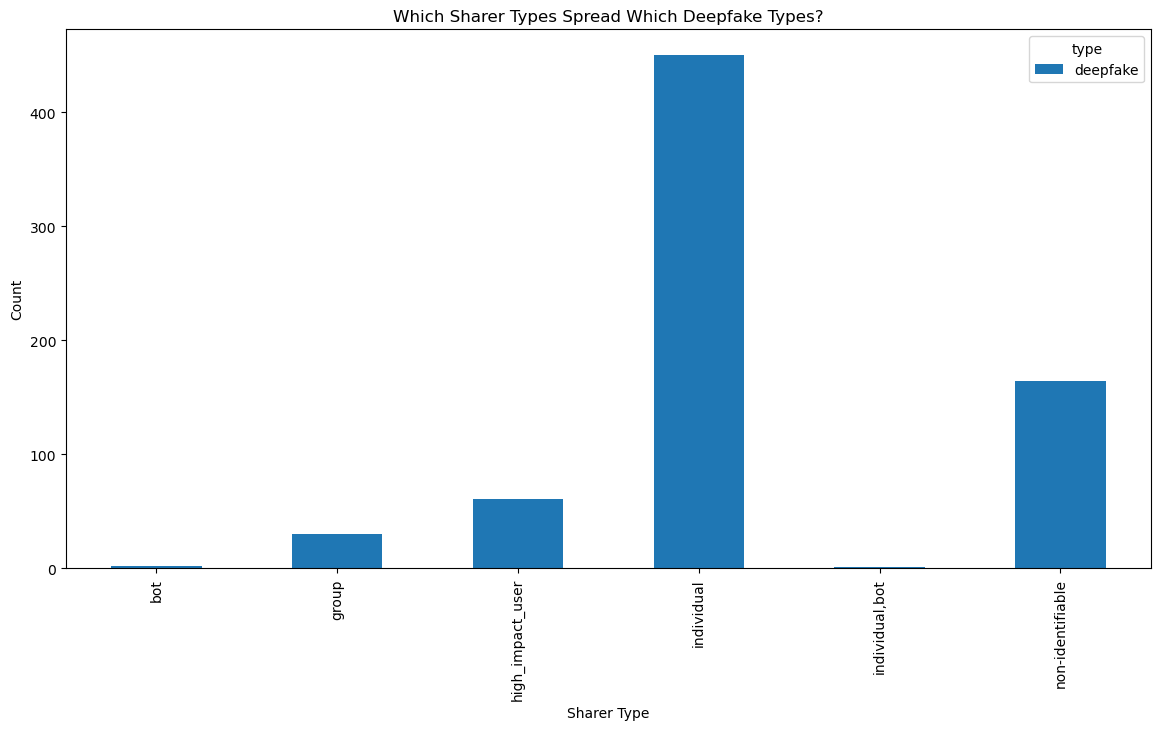

In [25]:
# Pivot table: sharer_type vs type of deepfake

pivot_table = pd.crosstab(df['sharer_type'], df['type'])

pivot_table.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Which Sharer Types Spread Which Deepfake Types?')
plt.xlabel('Sharer Type')
plt.ylabel('Count')
plt.show()


In [12]:
# contains trump 

In [13]:
# Drop missing sharer names
valid_sharers = df['sharer_name'].dropna()

# Normalize to lowercase and search for "trump" in name
contains_trump = valid_sharers.str.lower().str.contains('trump')

# Compute the percentage
num_trump_users = contains_trump.sum()
total_users = len(valid_sharers)
percentage_trump = (num_trump_users / total_users) * 100

print(f"🔍 Users with 'trump' in their name: {num_trump_users}")
print(f"👥 Total users: {total_users}")
print(f"📊 Percentage of users with 'trump' in name: {percentage_trump:.2f}%")


🔍 Users with 'trump' in their name: 42
👥 Total users: 703
📊 Percentage of users with 'trump' in name: 5.97%


In [14]:
from collections import Counter

# 1. Filter rows where sharer_name contains 'trump'
trump_sharers_df = df[df['sharer_name'].str.lower().str.contains('trump', na=False)]

# 2. Collect all target names (remove nulls and normalize)
targets = (
    trump_sharers_df['target_name'].dropna().tolist() +
    trump_sharers_df['target_one_name'].dropna().tolist() +
    trump_sharers_df['target_two_name'].dropna().tolist()
)

# 3. Clean: lowercase and strip whitespace
targets_clean = [t.strip().lower() for t in targets if isinstance(t, str) and t.strip() != '']

# 4. Count occurrences
target_counter = Counter(targets_clean)

# 5. Convert to DataFrame and sort
import pandas as pd
target_df = pd.DataFrame(target_counter.items(), columns=['target', 'count'])
target_df = target_df.sort_values(by='count', ascending=False)

# 6. Display results
print("🎯 Deepfake Targets by Sharers Containing 'Trump':")
print(target_df.head(15).to_string(index=False))


🎯 Deepfake Targets by Sharers Containing 'Trump':
                 target  count
           donald trump     34
           taylor swift      6
          kamala harris      5
              joe biden      4
              elon musk      3
donald trump ,joe biden      2
donald trump ,elon musk      2
           barack obama      2
        abraham lincoln      1
